In [1]:
import networkx as nx
import numpy as np
from scipy import random
import pandas as pd
import copy
import random
from collections import OrderedDict, Counter
from multiprocessing import Pool
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def generate_my_simplicial_complex_d2(N,p1,p2):
    
    """Our model"""
    
    #I first generate a standard ER graph with edges connected with probability p1
    G = nx.fast_gnp_random_graph(N, p1, seed=None)
    
    if not nx.is_connected(G):
        giant = list(nx.connected_components(G))[0]
        G = nx.subgraph(G, giant)
        print('not connected, but GC has order %i ans size %i'%(len(giant), G.size())) 

    triangles_list = []
    G_copy = G.copy()
    
    #Now I run over all the possible combinations of three elements:
    for tri in combinations(list(G.nodes()),3):
        #And I create the triangle with probability p2
        if random.random() <= p2:
            #I close the triangle.
            triangles_list.append(tri)
            
            #Now I also need to add the new links to the graph created by the triangle
            G_copy.add_edge(tri[0], tri[1])
            G_copy.add_edge(tri[1], tri[2])
            G_copy.add_edge(tri[0], tri[2])
            
    G = G_copy
             
    #Creating a dictionary of neighbors
    node_neighbors_dict = {}
    for n in list(G.nodes()):
        node_neighbors_dict[n] = G[n].keys()           
                
    #print len(triangles_list), 'triangles created. Size now is', G.size()
        
    #avg_n_triangles = 3.*len(triangles_list)/G.order()
    
    #return node_neighbors_dict, node_triangles_dict, avg_n_triangles
    #return node_neighbors_dict, triangles_list, avg_n_triangles
    return node_neighbors_dict, triangles_list

In [20]:
def get_p1_and_p2_correction(k1,k2,N):
    p2 = (2.*k2)/((N-1.)*(N-2.))
    p1 = (k1 - 2.*k2)/((N-1.)- 2.*k2)
    if (p1>=0) and (p2>=0):
        return p1, p2
    else:
        raise ValueError('Negative probability!')
        
def one_realization(ii):
    print('ITERATION %i'%ii)
    
    #Generating a simplicial complex with the given parameters
    node_neighbors_dict, triangles_list = generate_my_simplicial_complex_d2(N,p1,p2)

    return node_neighbors_dict, triangles_list
    
def parse_results(results):
    
    degree_list = []
    tri_degree_list = []
    
    for res in results:
        node_neighbors_dict, triangles_list = res
        
        #Adding the degree sequence of this realization to the global list
        degree_list += [len(neighs) for neighs in node_neighbors_dict.itervalues()]
    
        #creating a triangles degree sequence and adding it to the global list
        vertex_in_a_triangle = []
        for tri in triangles_list:
            vertex_in_a_triangle += tri
            
        tri_degree_list += Counter(vertex_in_a_triangle).values()

    degree_counter = Counter(degree_list)
    triangle_degree_counter = Counter(tri_degree_list)

    return degree_counter, triangle_degree_counter

Running in parallel

In [ ]:
#Simplicial Complex
N = 2000
k1 = 20
k2 = 6
p1, p2 = get_p1_and_p2_correction(k1,k2,N)

n_simulations = 80
n_processes = 8

#################################################

iteration_numbers = range(n_simulations)

pool = Pool(n_processes)                         
results = pool.map(one_realization, iteration_numbers)
degree_counter, triangle_degree_counter = parse_results(results)

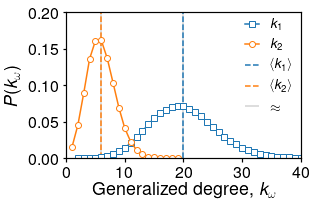

In [19]:
fig = plt.figure(figsize=(4.5,3));
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

ax = plt.subplot(111)

norm_k1 = 1.*np.array(degree_counter.values())/sum(degree_counter.values())
norm_k2 = 1.*np.array(triangle_degree_counter.values())/sum(triangle_degree_counter.values())

#################### plot pdf
ax.plot(degree_counter.keys(), norm_k1, 's-', label='$k_1$',
        clip_on=True, mfc='white');
ax.plot(triangle_degree_counter.keys(), norm_k2, 'o-', label='$k_2$',
        clip_on=True, mfc='white');


#################### real mean
sum_of_numbers = sum(number*count for number, count in degree_counter.iteritems())
count = sum(count for n, count in degree_counter.iteritems())
mean_k1 = float(sum_of_numbers) / count

sum_of_numbers = sum(number*count for number, count in triangle_degree_counter.iteritems())
count = sum(count for n, count in triangle_degree_counter.iteritems())
mean_k2 = float(sum_of_numbers) / count

ax.vlines(mean_k1,0,0.2, linewidth=1.5, linestyles='--',
          color=u'#1f77b4', label=r'$\langle k_1 \rangle$');
ax.vlines(mean_k2,0,0.2, linewidth=1.5, linestyles='--',
          color=u'#ff7f0e', label=r'$\langle k_2 \rangle$');

#################### expected mean
ax.vlines(k2,0,0.2, linewidth=1.5, linestyles='-', color='lightgray', zorder=1, label=r'$\approx$');
ax.vlines(k1,0,0.2, linewidth=1.5, linestyles='-', color='lightgray', zorder=1);

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Generalized degree, $k_\omega$', size=18)
ax.set_ylabel('$P(k_\omega)$', size=18)

ax.set_ylim(0,0.2);
ax.set_xlim(0,40);

plt.legend(fontsize=14, loc='upper right', handlelength=1, frameon=False, borderpad=0)

plt.tight_layout()